In [2]:
%load_ext autoreload
%autoreload 2

In [22]:
import os, shutil
import torch
import time
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
import pdb
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True,
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 15
                    }
                   )
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
import head
import numpy as np
from head.metrics import euclidean_dist
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.optim.optimize import optimize_acqf_discrete
from botorch.acquisition.monte_carlo import qUpperConfidenceBound, qExpectedImprovement
from botorch.acquisition.objective import LinearMCObjective
from matplotlib.cm import ScalarMappable


NUM_GRID_PERDIM = 100
BATCH_SIZE = 8
N_ITERATIONS = 10
NUM_RESTARTS = 64 
RAW_SAMPLES = 1024
N_INIT_SAMPLES = 8
NUM_FILTERS = 5

TARGET = [1,0,0.5]
expt = {}
EXPT_ID = 0

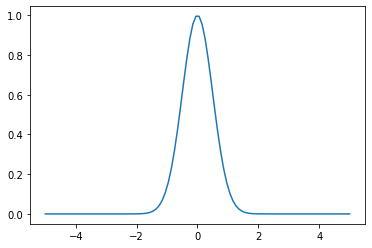

In [4]:
lambda_ = np.linspace(-5,5,num=100)
def gaussian(a, b,c):
    return a*np.exp(-np.power(lambda_ - b, 2.) / (2 * np.power(c, 2.)))

yt = gaussian(*TARGET)

fig, ax = plt.subplots()
ax.plot(lambda_, yt)
plt.show()

In [5]:
# define search space
A = [-5,5]
bounds = torch.tensor(A).reshape(2,1).to(**tkwargs)
bounds.shape

torch.Size([2, 1])

In [6]:
def L2(f1, f2):
    return np.trapz(f1*f2, x=(lambda_-min(lambda_))/(max(lambda_)-min(lambda_)))

def d(v,w):
    return -L2(v-w, v-w)

d(yt, yt)

-0.0

In [7]:
def oracle(x):
    """Scoring function at a given input location
    Uses the simulator sim to generate response spectra at a given locations
    and return a similarity score to target spectra
    """
    global EXPT_ID
    x_np = x.cpu().numpy()
    yi = gaussian(TARGET[0],x_np,TARGET[2])
    dist = d(yi, yt)
        
    expt[EXPT_ID] = [lambda_, yi, dist]
    EXPT_ID += 1
    
    return torch.tensor([dist])

def batch_oracle(x):
    out = []
    for xi in x.squeeze(1):
        out.append(oracle(xi))
    return torch.stack(out, dim=0).to(**tkwargs)

In [8]:
from botorch.utils.sampling import draw_sobol_samples

def draw_random_batch(n_samples=6):
    train_x = draw_sobol_samples(
        bounds=bounds,n=1, q=n_samples, 
        seed=torch.randint(2021, (1,)).item()
    ).squeeze(0)
    train_obj = batch_oracle(train_x)
    return train_x, train_obj


train_x, train_obj = draw_random_batch(n_samples=N_INIT_SAMPLES)
print('Generated %d samples randomly'%N_INIT_SAMPLES, train_x.shape, train_obj.shape)
for i in range(N_INIT_SAMPLES):
    print('%d\t%s\t%s'%(i, train_x[i,...].numpy(), train_obj[i,...].numpy()))

Generated 8 samples randomly torch.Size([8, 1]) torch.Size([8, 1])
0	[2.54576445]	[-0.17697377]
1	[-3.45083222]	[-0.1772436]
2	[1.513381]	[-0.15930215]
3	[0.45167208]	[-0.03270955]
4	[-3.70705888]	[-0.1772328]
5	[-4.94805926]	[-0.13807439]
6	[4.1697675]	[-0.17637387]
7	[1.87592745]	[-0.17199432]


In [9]:
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, 
    outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_obj)

In [10]:
from botorch.optim.optimize import optimize_acqf

def selector(f, q = BATCH_SIZE):
    new_x, _ = optimize_acqf(
        acq_function=f,
        bounds=bounds,
        q=q,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES, 
        sequential=False,
    )
    new_obj = batch_oracle(new_x)
    return new_x, new_obj

In [11]:
torch.manual_seed(2021)
import pdb

# run N_ITERATIONS rounds of BayesOpt after the initial random batch
print('Sampled ID \t Locations \t Objectives')
for iteration in range(1, N_ITERATIONS + 1):    
    print('Iteration : %d/%d'%(iteration, N_ITERATIONS))
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition module
    #acquisition = qUpperConfidenceBound(model, beta=0.1)
    best_f = train_obj.max(axis=0).values
    acquisition = qExpectedImprovement(model, best_f = best_f)
    
    # optimize acquisition functions and get new observations
    new_x, new_obj = selector(acquisition)
    for i in range(BATCH_SIZE):
        print('%d\t%s\t%s'%(i, new_x[i,...].numpy(), new_obj[i,...].numpy()))

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])

    # re-initialize
    mll, model = initialize_model(train_x, train_obj)

Sampled ID 	 Locations 	 Objectives
Iteration : 1/10
0	[0.39134458]	[-0.02516875]
1	[0.26870814]	[-0.01234673]
2	[0.55896303]	[-0.04756207]
3	[-0.12068586]	[-0.00256288]
4	[-0.57792421]	[-0.0503277]
5	[-4.40210649]	[-0.17312376]
6	[0.70068125]	[-0.06876375]
7	[0.11327205]	[-0.00225963]
Iteration : 2/10
0	[0.01148166]	[-2.33644401e-05]
1	[-2.34024675]	[-0.17650399]
2	[-0.01178456]	[-2.46133806e-05]
3	[2.30879608]	[-0.17638726]
4	[-1.09869869]	[-0.12423985]
5	[-0.62247797]	[-0.05693724]
6	[-3.58132932]	[-0.17724194]
7	[-4.53574387]	[-0.16873057]
Iteration : 3/10
0	[0.30042435]	[-0.01529657]
1	[2.62332593]	[-0.17706349]
2	[-0.5946825]	[-0.0527974]
3	[0.78401161]	[-0.08138806]
4	[-0.69755277]	[-0.06828817]
5	[0.0100239]	[-1.78084534e-05]
6	[0.50206376]	[-0.03949171]
7	[-0.01060626]	[-1.99376995e-05]
Iteration : 4/10
0	[-0.20270134]	[-0.00713504]
1	[-0.0108799]	[-2.09796737e-05]
2	[0.0093578]	[-1.55204179e-05]
3	[2.57139044]	[-0.17700715]
4	[4.12738092]	[-0.17661545]
5	[-2.5199986]	[-0.1769

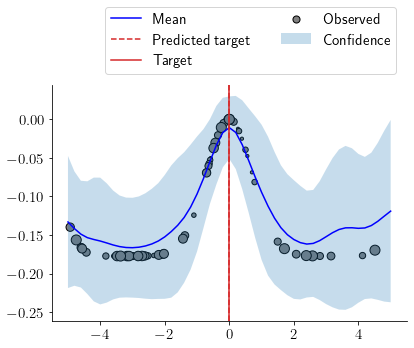

In [35]:
# Get into evaluation (predictive posterior) mode
from botorch.acquisition import PosteriorMean
batch_number = torch.cat(
    [torch.zeros(N_INIT_SAMPLES), 
     torch.arange(1, N_ITERATIONS+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()

model.eval()
mll.eval()
test_x = torch.linspace(-5, 5, 51).to(**tkwargs)
fig, ax = plt.subplots()
with torch.no_grad():
    posterior = model.posterior(test_x)
    lower, upper = posterior.mvn.confidence_region()
    ax.scatter(train_x.cpu().numpy(), train_obj.cpu().numpy(), s=10*batch_number,c='grey', 
               edgecolors=(0,0,0), label='Observed')
    ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b', label='Mean')
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), 
                    upper.cpu().numpy(), alpha=0.25, label='Confidence')

opt_x, opt_obj = selector(PosteriorMean(model), q=1)
opt_x = opt_x.cpu().numpy().squeeze()
ax.axvline(opt_x, color='tab:red', ls='--', label='Predicted target')
ax.axvline(TARGET[1], color='tab:red', label='Target')
fig.legend(ncol=2,loc='center', bbox_to_anchor=(0.6, 1.1))
plt.tight_layout()
plt.show()

In [ ]:
from matplotlib import cm
from matplotlib.colors import Normalize

all_scores = [v[2] for _, v in expt.items()]
norm = Normalize(vmin=min(all_scores), vmax=max(all_scores))
cmap = cm.get_cmap('viridis')
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

for b in np.unique(batch_number):
    fig, ax = plt.subplots(1,1)
    fig.suptitle('Batch number %d'%b)
    for i in np.argwhere(batch_number==b).squeeze():
        ax.plot(expt[i][0], expt[i][1],
                      color=cmap(norm(expt[i][2])))
    cbar = fig.colorbar(mappable,ax=ax)
    plt.show()